<a href="https://colab.research.google.com/github/davorrunje/ChatGPT_Clone/blob/main/TNN_Ground_State_1D_float32_davor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Luka Grubišić, Marko Hajba


---

We are solving the time-independent Schrödinger equation in one dimension using the Variational Physical Informed Neural Network (VPINN).
$$\begin{equation}
-\triangle u+V_\omega u~ =\varepsilon u .
\end{equation}$$

---

Potential $V$ is generated as linear combination of the finite well and two inverted Gaussians,
$$V=-\alpha_1 \exp(-\|\cdot-c_1\|)^2/k_1^2)-\alpha_2 \exp(-\|\cdot-c_2\|)^2/k_2^2)-h\boldsymbol 1_{\{x:~|x-c| < t\}}.
$$
We use $\boldsymbol 1_{\{x:~|x-c| < t\}}$ to denote the indicator function and choose $\alpha_i\in[8,12]$, $c_i\in[-2.5,2.5]$, $k_i\in[0.9,2.6]$, $i=1,2$, $h\in[10,15]$, $c\in[-2,2]$ , $t\in[0.5,2.5]$.

---

Loss function used: $$L(u;\beta,\eta)=\dfrac{\int_{\Omega}|\nabla u|^2+\int_{\Omega}V_{\omega}u^2}{\int_{\Omega}u}+\beta(u^2(B)+u^2(-B))+\eta\left(\int_{\Omega}u^2-1\right),$$

---

To compute the residuals and the energy of the modes we use a Gaussian quadrature where the deep network is evaluated at the sufficient number -- for the given interval $(-B,B)$ -- of Gaussian points. In this example we used 1024 quadrature points on an interval  $(-6,6)$.

A-posteriori (residual) error estimator
$$
\Delta_\varepsilon^2=\|H \psi-\varepsilon\psi\|^2/(\varepsilon^2\|\psi\|^2)~
$$
is used to monitor performance of the training of the VPINN and it is good stopping criteria. For full algorithm and more details you can read the paper.

Let us also emphasize that $\Delta_\varepsilon$ measures the distance of the Rayleigh Quotient (energy functional) to the nearest eigenvalue. This algorithm can be used in higher dimensional space, but different quadrature rules should be used.

---

To benchmark the accuracy of the VPINN approximations we have solved the problem to high relative accuracy using the Chebyshev spectral method as implemented in the package $\texttt{chebfun}$. We emphasize that \texttt{chebfun} was not used during the training of the network in any way. Tensorial neural network architecture is used. Activation function $\rho(x)=\exp(-x^2/10)$ is used to enforce positivity of the solution.



In [1]:
# !pip install t3f "numpy<1.24" tensorflow==2.16.1
# !pip uninstall -y tensorflow tf-keras numpy tensorflow-hub
# !pip install t3f "tensorflow<2.15" "numpy<1.24" chex optax

!pip install t3f "tensorflow~=2.15.0" "numpy~=1.23.0"


In [2]:
# system packages
import random
import os
import time

from datetime import datetime
from pathlib import Path
from typing import Callable, Dict, Optional, Tuple

# 3th party packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import tensorflow as tf
import t3f

from scipy.interpolate import CubicSpline
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import backend as K

for m in [tf, np, scipy, matplotlib]:
    print(f"{m.__name__:12}: {m.__version__}")


tensorflow  : 2.15.0
numpy       : 1.23.5
scipy       : 1.11.4
matplotlib  : 3.7.1


In [3]:
%matplotlib inline

# set random seeds
seed = 1

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# not sure this is needed
tf.keras.backend.set_floatx('float32')

## Constants


In [41]:
NX = 4096
INPUT_DIM = 1
HIDDEN_DIM = 5

## Data

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
path_root = Path('/content/drive/MyDrive/VPINN_Hajba_Grubisic/1D_TNN_GroundState')
ground_state_1D_data_path_name = 'ground_state_1D_data.mat'
ground_state_1D_data_path = path_root / ground_state_1D_data_path_name

assert ground_state_1D_data_path.exists(), ground_state_1D_data_path

In [44]:
def load_data_from_drive(path: str) -> Dict[str, tf.Tensor]:
  print(f"Loading data from {path}...")
  try:
    mat = sio.loadmat(path)
    print(f"Data loaded: {mat['__header__']}, version={mat['__version__']}")
    def convert2tf(k: str, v: np.ndarray) -> tf.Tensor:
      retval = tf.reshape(tf.cast(v, dtype='float32'), (-1, ))
      print(
          f" - {k:10}: np(dtype={v.dtype}, shape={v.shape}) -> "
          f"tf(dtype={retval.dtype}, shape={retval.shape})"
      )
      return retval

    xs = {k: convert2tf(k, v) for k, v in mat.items() if not k.startswith('__')}

    return xs

  except Exception as e:
    print(f"Error loading data: {e}")
    raise

def plot_loaded_data(
  loaded_data: Dict[str, tf.Tensor],
  # key: str,
  *,
  log_yscale: bool = True,
  figsize: Optional[Tuple[int, int]] = None,
  fontsize: int = 15,
) -> None:
  if figsize:
    plt.figure(figsize=figsize)

  x_d = loaded_data['x_d']
  U0_comb = loaded_data['U0_comb']

  plt.scatter(x_d, U0_comb, alpha=0.8, s=4)
  if log_yscale:
    plt.yscale("log")
  plt.xlabel('x', fontsize = fontsize)
  plt.ylabel('$U0_{comb}$', fontsize = fontsize)
  plt.show()

Loading data from /content/drive/MyDrive/VPINN_Hajba_Grubisic/1D_TNN_GroundState/ground_state_1D_data.mat...
Data loaded: b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Dec 31 16:13:13 2020', version=1.0
 - A1_comb   : np(dtype=float64, shape=(1, 1)) -> tf(dtype=<dtype: 'float32'>, shape=(1,))
 - A2_comb   : np(dtype=float64, shape=(1, 1)) -> tf(dtype=<dtype: 'float32'>, shape=(1,))
 - c1_comb   : np(dtype=float64, shape=(1, 1)) -> tf(dtype=<dtype: 'float32'>, shape=(1,))
 - c2_comb   : np(dtype=float64, shape=(1, 1)) -> tf(dtype=<dtype: 'float32'>, shape=(1,))
 - k1_comb   : np(dtype=float64, shape=(1, 1)) -> tf(dtype=<dtype: 'float32'>, shape=(1,))
 - k2_comb   : np(dtype=float64, shape=(1, 1)) -> tf(dtype=<dtype: 'float32'>, shape=(1,))
 - h_comb    : np(dtype=float64, shape=(1, 1)) -> tf(dtype=<dtype: 'float32'>, shape=(1,))
 - cfw_comb  : np(dtype=float64, shape=(1, 1)) -> tf(dtype=<dtype: 'float32'>, shape=(1,))
 - t_comb    : np(dtype=float64, shape=(1, 1)) -> tf(dtype=<

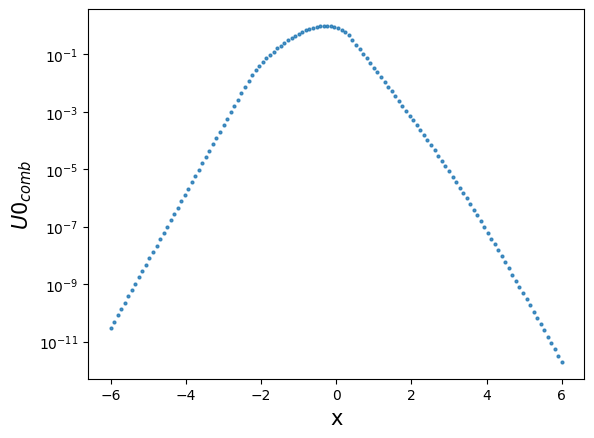

In [45]:
loaded_data = load_data_from_drive(ground_state_1D_data_path)
plot_loaded_data(loaded_data)
# x_d

## Generate Gaussian quadrature points and weights

In [46]:
def generate_gaussian_quadrature_points(
    *,
    nx: int = NX,
    dim: int = INPUT_DIM,
    loaded_data: Dict[str, tf.Tensor] = loaded_data
) -> Tuple[tf.Tensor, tf.Tensor]:
  a, b = np.min(loaded_data['x_d']), np.max(loaded_data['x_d'])

  # generate Gaussian quadrature points on [a, b]
  x1, w = tf.constant(scipy.special.roots_legendre(nx))

  ####### Gaussian quadrature points on [a, b]
  x = 0.5*(x1 + 1)*(b - a) + a

  # gauss = sum(w * f(t)) * 0.5*(b - a)
  x = tf.reshape(x, [nx,] )
  w = tf.reshape(w, [nx,] )
  x = tf.cast(x, dtype='float32')
  w = tf.cast(w, dtype='float32')

  return x, w

def plot_gaussian_quadrature_points(
  x: tf.Tensor,
  w: tf.Tensor,
  *,
  log_yscale: bool = True,
  figsize: Optional[Tuple[int, int]] = None,
  fontsize: int = 15,
) -> None:
  if figsize:
    plt.figure(figsize=figsize)
  plt.scatter(x, w, alpha=0.8, s=4)
  if log_yscale:
    plt.yscale("log")
  plt.xlabel('x', fontsize = fontsize)
  plt.ylabel('w', fontsize = fontsize)
  plt.show()

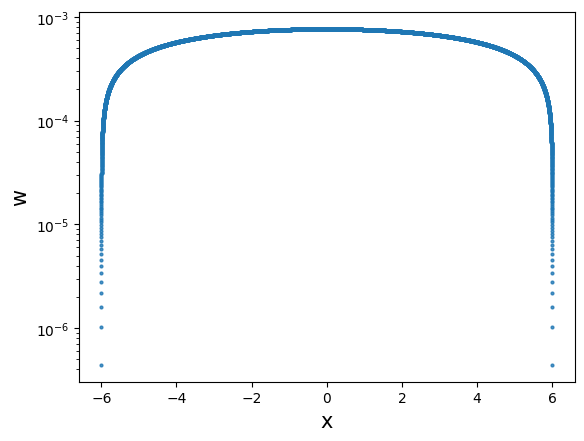

In [47]:
x, w = generate_gaussian_quadrature_points()

plot_gaussian_quadrature_points(x, w)

## Potential $V$

In [48]:
## define potentials

def V_comb(xi, loaded_data: Dict[str, tf.Tensor]) -> tf.Tensor:
  A1_comb = loaded_data['A1_comb']
  A2_comb = loaded_data['A2_comb']
  c1_comb = loaded_data['c1_comb']
  c2_comb = loaded_data['c2_comb']
  k1_comb = loaded_data['k1_comb']
  k2_comb = loaded_data['k2_comb']
  h_comb = loaded_data['h_comb']
  cfw_comb = loaded_data['cfw_comb']
  t_comb = loaded_data['t_comb']
  return -(
    A1_comb * tf.exp(-((xi-c1_comb)/k1_comb)**2)
    + A2_comb * tf.exp(-((xi-c2_comb)/k2_comb)**2)
    + tf.where( tf.abs(xi - cfw_comb) < t_comb, h_comb, 0)
  )

def plot_potentials(
  V_d: tf.Tensor,
  *,
  figsize: Optional[Tuple[int, int]] = None,
  fontsize: int = 15,
) -> None:
  if figsize:
    plt.figure(figsize=figsize)

  plt.plot(x, V_d, 'tab:orange', linewidth=5, label='V(x)')

  # plt.legend(fontsize = fontsize, loc = 1)
  plt.xticks(fontsize = fontsize)
  plt.yticks(fontsize = fontsize)
  plt.xlabel('x', fontsize = fontsize)
  plt.ylabel('V(x)', fontsize = fontsize)


In [49]:
class MyTrainer(tf.keras.Model):
  def __init__(self, loaded_data: Dict[str, tf.Tensor], *args, **kwargs):
    super(MyTrainer, self).__init__(*args, **kwargs)
    # V_d = tf.cast(tf.reshape(V_comb(x, loaded_data), (len(x),)), dtype = 'float32')
    # energy = loaded_data["EV_comb"]
    # U0d = loaded_data["U0_comb"]
    # a, b = np.min(x), np.max(x)
    # lbc = tf.constant([a])
    # rbc = tf.constant([b])
    # beta = 0.00001
    # eta = 20
    self.loaded_data = loaded_data

    self.EV = loaded_data["EV_comb"][0]

  def train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      inputs, _ = data
      x = inputs["inputs"]
      trainable_vars = self.trainable_variables
      print(f"{trainable_vars=}")

      # raise ValueError(f"{data=}")

      ########################################################################
      #
      # forward with gradient tapes
      #
      # the first and the second derivate wrt x calculated
      #

      dbc = tf.constant([6])
      with tf.GradientTape() as tape:
        with tf.GradientTape() as xx_tape:
          xx_tape.watch(x)

          with tf.GradientTape() as x_tape:
            x_tape.watch(x)

            y_pred = self(x, training = True)

          x_grad = x_tape.gradient(y_pred, x)   # Will compute first derivative
        xx_grad = xx_tape.gradient(x_grad, x)   # Will compute the second derivative

        # not sure if we should reashape them
        print(f"{y_pred.shape=}, {tf.reshape(y_pred, (-1,) )=}")
        print(f"{x_grad.shape=}, {tf.reshape(x_grad, (-1,) )=}")
        print(f"{xx_grad.shape=}, {tf.reshape(xx_grad, (-1,) )=}")
        y_pred = tf.reshape(y_pred, (-1, ))
        x_grad = tf.reshape(x_grad, (-1,) )
        xx_grad = tf.reshape(xx_grad, (-1,) )



      ########################################################################
      #
      # loss function begin (still using outer gradient tape)

        y_pred_sq = tf.square(y_pred)

        # integral
        pred_int_2 = tf.math.reduce_sum(tf.multiply(w, y_pred_sq)*(b-a)*0.5)

        # integral
        loss_value = tf.math.reduce_sum(tf.multiply(w, tf.square(x_grad))*(b-a)*0.5)

        # integral
        loss_value = loss_value + tf.math.reduce_sum(tf.multiply(w, tf.multiply(V_d, y_pred_sq))*(b-a)*0.5)

        loss_value = loss_value / pred_int_2

        ## add penalization to enforce boundary conditions of the ground-state, parametar $\eta$
        loss_value = loss_value  + beta * (tf.square(self(lbc)) + tf.square(self(rbc)))

        ## add penalization to enforce normalization of the ground-state, parametar $\eta$
        loss_value = loss_value + eta * tf.math.square(tf.math.reduce_sum(tf.multiply(w, y_pred_sq)*(b-a)*0.5) - 1)

      # Compute gradients
      gradients = tape.gradient(loss_value, trainable_vars)

      # Update weights
      if hasattr(self.optimizer, "apply"):
        # tf 2.16 and above
        self.optimizer.apply(gradients, trainable_vars)
      else:
        # tf 2.15 and below
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

      # end of loss function
      #
      ########################################################################
      #
      # A-posteriori (residual) error estimator

      ham = -xx_grad + tf.multiply(V_d, y_pred)
      ham = tf.reshape(ham, (-1, ) )

      e = tf.math.reduce_sum(tf.multiply(w, tf.multiply(ham, y_pred))*(b-a)*0.5)/pred_int_2

      eq_res = tf.math.reduce_sum(tf.multiply(w, tf.square(ham - e*y_pred ))*(b-a)*0.5)/ tf.multiply(tf.math.abs(e*e), pred_int_2)

      ########################################################################
      #
      # Relative error of the ground state energy in strong sense

      ritz_res_strong = tf.math.abs((self.EV-e)/e)

      ########################################################################
      #
      # relative error of the ground state energy in weak (variational) sense

      e_w = tf.math.reduce_sum(tf.multiply(w, tf.square(x_grad))*(b-a)*0.5)
      e_w = e_w + tf.math.reduce_sum(tf.multiply(w, tf.multiply(V_d, y_pred_sq))*(b-a)*0.5)
      e = e / pred_int_2

      ritz_res_weak = tf.math.abs((self.EV-e_w)/e_w)


      ########################################################################

      # Update metrics (includes the metric that tracks the loss)
      # for metric in self.metrics:
      #     if metric.name == "loss":
      #         metric.update_state(loss_value)
      #     else:
      #         metric.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      # return {m.name: m.result() for m in self.metrics}
      # return {}
      return {"loss": loss_value, "residual_scaled": eq_res, "ritz_strong": ritz_res_strong, "ritz_week": ritz_res_weak}

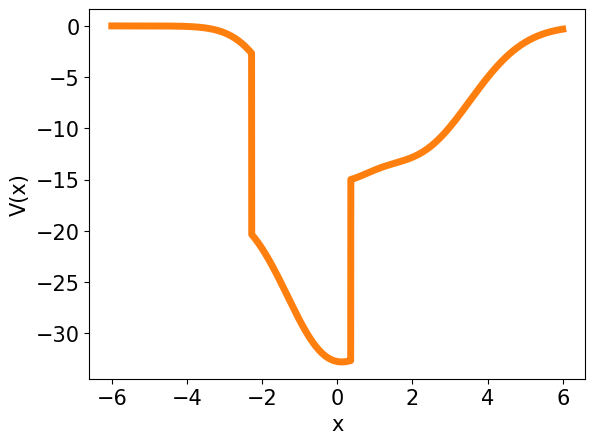

In [50]:
V_d = V_comb(x, loaded_data=loaded_data)

plot_potentials(V_d)

## Neural network architecture

In [51]:
## define custom activation
def activ(x):
    return tf.keras.activations.exponential(-0.1*x*x)

def plot_activation_function(
  a: Callable[[tf.Tensor], tf.Tensor],
  *,
  figsize: Optional[Tuple[int, int]] = None,
  fontsize: int = 15,
) -> None:
  if figsize:
    plt.figure(figsize=figsize)

  x = tf.linspace(-10, 10, 100)
  y = a(x)
  plt.plot(x, y, 'tab:orange', linewidth=5, label='V(x)')

  # plt.legend(fontsize = fontsize, loc = 1)
  plt.xticks(fontsize = fontsize)
  plt.yticks(fontsize = fontsize)
  plt.xlabel('x', fontsize = fontsize)
  plt.ylabel('activation(x)', fontsize = fontsize)


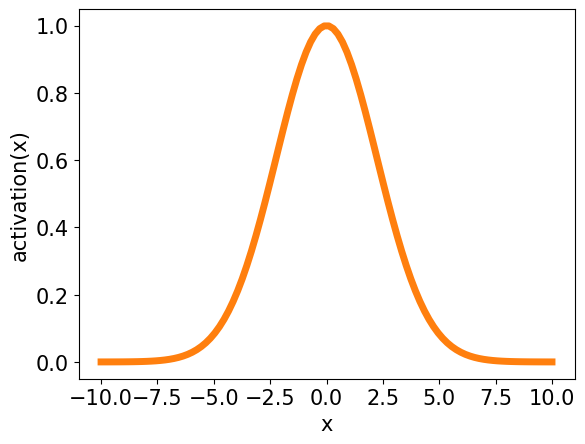

In [52]:
plot_activation_function(activ)

In [53]:
def build_model(*, hidden_dim: int = HIDDEN_DIM, input_dim: int = INPUT_DIM, loaded_data: Dict[str, tf.Tensor] = loaded_data) -> tf.keras.Model:
  print(f"Building model with input_dim={input_dim}, hidden_dim={hidden_dim}...")

  inputs = layers.Input(
    shape = (input_dim, ),
    name = "inputs",
    dtype = 'float32'
  )

  # questions:
  # - why output_dims = (3, )
  # - why tanh?
  # - why bias initializer?
  # - why t3f?
  # - why custom activation function at output
  tt_layer1 = t3f.nn.KerasDense(
      input_dims=(input_dim, 1),
      output_dims = (hidden_dim, hidden_dim),
      tt_rank=8,
      # activation='tanh',
      activation='elu',
      bias_initializer=1e-3
  )(inputs)
  tt_layer2 = t3f.nn.KerasDense(
    input_dims=(hidden_dim, hidden_dim),
    output_dims = (1, 1),
    tt_rank=8, activation='linear',
    kernel_initializer='glorot',
    bias_initializer=1e-3
  )(tt_layer1)

  out = activ(tt_layer2)

  # model = tf.keras.Model(inputs = inputs, outputs = [out])
  model = MyTrainer(inputs = inputs, outputs = [out], loaded_data=loaded_data)

  return model


In [54]:
# check model arhitecture
model = build_model()
model.summary()

Building model with input_dim=1, hidden_dim=5...
Model: "my_trainer_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 tt_dense_10 (KerasDense)    (None, 25)                   105       ['inputs[0][0]']              
                                                                                                  
 tt_dense_11 (KerasDense)    (None, 1)                    81        ['tt_dense_10[0][0]']         
                                                                                                  
 tf.math.multiply_10 (TFOpL  (None, 1)                    0         ['tt_dense_11[0][0]']         
 ambda)                               

## Choose the problem example from dataset to solve

In [55]:
## choose the problem example
V_d = tf.cast(tf.reshape(V_comb(x, loaded_data), (len(x),)), dtype = 'float32')
energy = loaded_data["EV_comb"]
U0d = loaded_data["U0_comb"]
a, b = np.min(x), np.max(x)
lbc = tf.constant([a])
rbc = tf.constant([b])
beta = 0.00001
eta = 20

## compile model with chosen lr and metrics to monitor
model = build_model()
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss = None, optimizer=optim)
model.summary()

Building model with input_dim=1, hidden_dim=5...
Model: "my_trainer_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 tt_dense_12 (KerasDense)    (None, 25)                   105       ['inputs[0][0]']              
                                                                                                  
 tt_dense_13 (KerasDense)    (None, 1)                    81        ['tt_dense_12[0][0]']         
                                                                                                  
 tf.math.multiply_12 (TFOpL  (None, 1)                    0         ['tt_dense_13[0][0]']         
 ambda)                               

In [60]:
no_steps_in_epoch = 500

ds_train = (
    tf.data.Dataset.from_tensor_slices(({"inputs": x}, tf.zeros_like(x)))
    .repeat(no_steps_in_epoch)
    # .shuffle(len(x)*no_steps_in_epoch)
    .batch(len(x))
)
ds_train, len(ds_train)

(<_BatchDataset element_spec=({'inputs': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 500)

Train the model:

- callback could be added to stop training when approximation is accurate enough, to adjust learning rate etc.

In [61]:
## train the model
## callback can be used to monitor $\Delta_\epsilon^2$ and stop training if error estimator is small enough,
#  otherwise we can continue training for additional epochs or change the arhitecture of the neural network
# no_epoch = 118
no_epoch = 120

start = time.time()
history = model.fit(ds_train, epochs = no_epoch)

print('Training time: ', np.round(time.time()-start, 2), ' s')

Epoch 1/120
500/500 [==============================] - 5s 11ms/step - loss: -29.4341 - residual_scaled: 0.0050 - ritz_strong: 0.0024 - ritz_week: 0.0087
Epoch 2/120
500/500 [==============================] - 7s 13ms/step - loss: -29.4440 - residual_scaled: 0.0047 - ritz_strong: 0.0020 - ritz_week: 0.0081
Epoch 3/120
500/500 [==============================] - 5s 9ms/step - loss: -29.4524 - residual_scaled: 0.0045 - ritz_strong: 0.0018 - ritz_week: 0.0076
Epoch 4/120
500/500 [==============================] - 5s 10ms/step - loss: -29.4590 - residual_scaled: 0.0042 - ritz_strong: 0.0015 - ritz_week: 0.0071
Epoch 5/120
500/500 [==============================] - 7s 13ms/step - loss: -29.4643 - residual_scaled: 0.0040 - ritz_strong: 0.0014 - ritz_week: 0.0065
Epoch 6/120
500/500 [==============================] - 5s 9ms/step - loss: -29.4689 - residual_scaled: 0.0038 - ritz_strong: 0.0012 - ritz_week: 0.0058
Epoch 7/120
500/500 [==============================] - 6s 13ms/step - loss: -29.4735

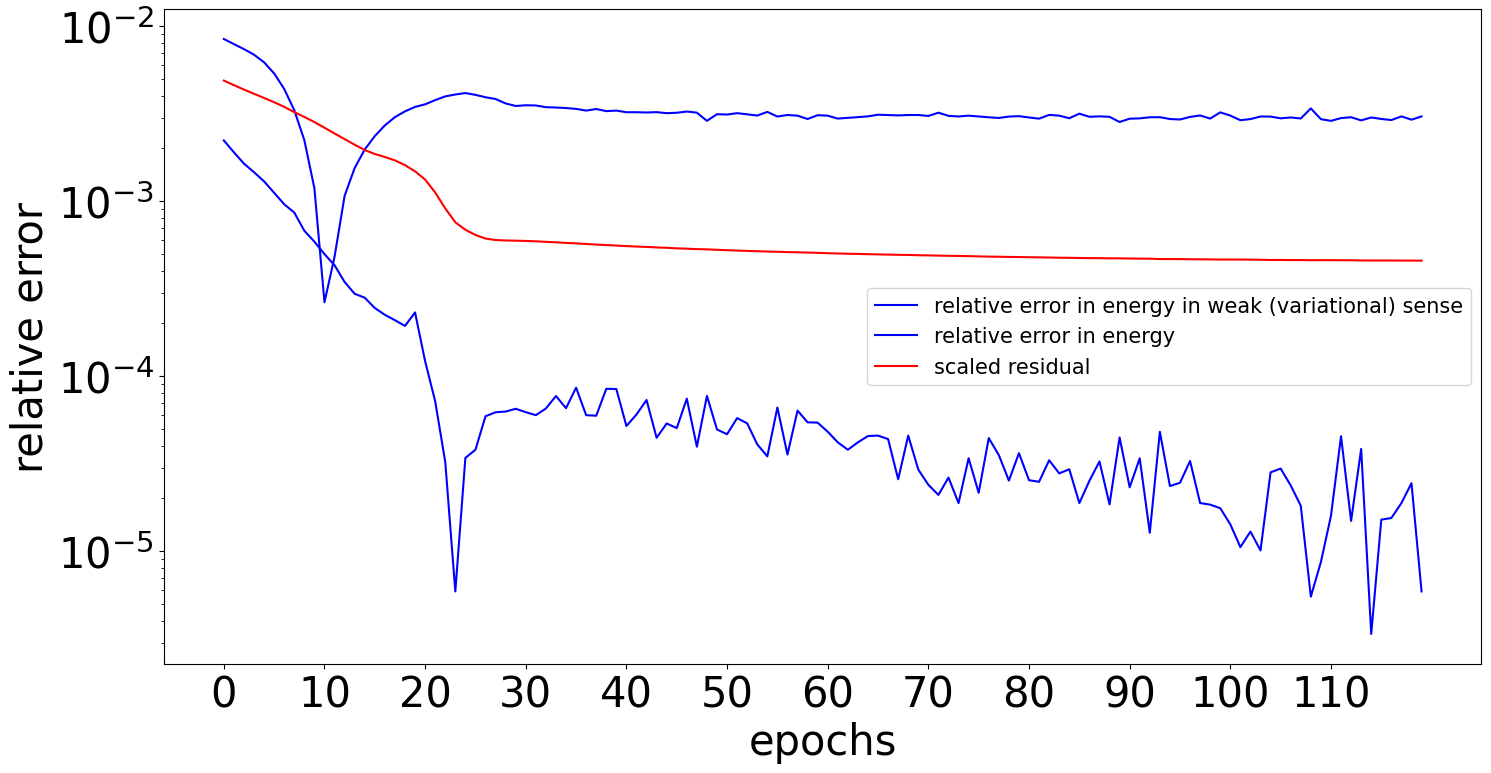

In [62]:
## plot relative error in the ground state energy and scaled residual $\Delta_\epsilon^2$
def plot_relative_error(history):
  plt.figure(figsize=(2*8.5, 8.5))
  plt.semilogy(history.history['ritz_week'], 'b', label = 'relative error in energy in weak (variational) sense')
  plt.semilogy(history.history['ritz_strong'], 'b', label = 'relative error in energy')
  plt.semilogy(history.history['residual_scaled'], 'r', label = 'scaled residual')

  plt.legend(fontsize=15)
  plt.yticks(fontsize=30)
  plt.xlabel('epochs', fontsize=30)
  plt.ylabel('relative error', fontsize=30)
  xticks_d = [i * 10 for i in range(len(history.history["residual_scaled"]) // 10)]
  xlabels = [f'{label:,}' for label in xticks_d]
  plt.xticks(xticks_d, xlabels, fontsize=30)
  plt.show()

plot_relative_error(history)

In [63]:
assert False

AssertionError: 

In [ ]:
history.history.keys()

# Analysis of the TNN approximation

- calculate the ground eigenvalue and compare it w.r.t. Chebfun solution

In [ ]:
## analyse ground state and ground state energy accuracy
pred_data = model(x)
NN_d = tf.reshape(pred_data, (len(x), ))
with tf.GradientTape() as g:
    g.watch(x)
    pred = model(x)
grad = g.gradient(pred, x)     # Will compute f

e0_NN = tf.math.reduce_sum(tf.multiply(w, tf.square(grad))*(b-a)*0.5)
e0_NN = e0_NN + tf.math.reduce_sum(tf.multiply(w, tf.multiply(V_d, tf.square(NN_d)))*(b-a)*0.5)
e0_NN = e0_NN / tf.math.reduce_sum(tf.multiply(w, tf.square(NN_d))*(b-a)*0.5)

e0_cheb = energy[0].astype('float32')

rel_err_e0 = tf.math.abs((e0_cheb - e0_NN)/e0_NN)

print('e0 from Chebfun:', e0_cheb)
print('e0 from NN:', e0_NN.numpy())
print('Last loss value', history.history['loss'][no_epoch-1])
print('Relative error in energy:', "{:.4e}".format((tf.math.abs(e0_cheb - e0_NN)/(tf.math.abs(e0_cheb)))))
print('Relative error in energy using last metric value:',"{:.4e}".format(history.history['ritz_w'][no_epoch-1] ))
print('L2 norm of NN solution', "{:.4e}".format(tf.math.sqrt(tf.math.reduce_sum(tf.multiply(w, tf.square(NN_d))*(b-a)*0.5))))


In [ ]:
## plot solutions
U0d = tf.reshape(U0d, [nodes,1] )

plt.figure(figsize=(20, 9))
ax = plt.subplot(1,2, 1)
plt.plot(x, -V_d, 'tab:orange', linewidth=5, label='-V(x)')
plt.plot(x_d, U0d, 'b', linewidth=5, label='$\psi_{chebfun}(x)$')
pred_data = model(x)
NN_d = tf.reshape(np.abs(pred_data), (len(x), ))
plt.plot(x, NN_d, 'r--',  linewidth=5, label='$\psi_{NN}(x)$')

plt.legend(fontsize = 25, loc = 1)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel('x', fontsize = 30)

ax = plt.subplot(1,2, 2)
plt.plot(x_d, U0d, 'b', linewidth=5, label='$\psi_{chebfun}(x)$')
pred_data = model(x)
NN_d = tf.reshape(np.abs(pred_data), (len(x), ))
plt.plot(x, NN_d, 'r--',  linewidth=5, label='$\psi_{NN}(x)$')

plt.legend(fontsize = 25, loc = 1)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel('x', fontsize = 30)
plt.ylabel('$\psi(x)$', fontsize = 30)
plt.show()

## Another test of the TNN approximation

- choose a different set of Gaussian quadrature points and weights (expect more accurate approximation if more points chosen)

In [ ]:
#######################
## Additional testing #
#######################

nt = 8192

a = -6
b = 6
# generate Gaussian quadrature points on [-1, 1]
[x1, wt] = tf.constant(scipy.special.roots_legendre(nt))

####### Gaussian quadrature points on [a, b]
xt = 0.5*(x1 + 1)*(b - a) + a
# gauss = sum(w * f(t)) * 0.5*(b - a)
xt = tf.reshape(xt, [nt,] )
wt = tf.reshape(wt, [nt,] )

xt = tf.cast(xt, dtype='float32')
wt= tf.cast(wt, dtype='float32')

In [ ]:
V_t = V_comb(xt)
V_t = tf.cast(V_t, dtype = 'float32')

pred_t = model(xt)
NN_dt = tf.reshape(pred_t, (len(xt), ))
with tf.GradientTape() as g:
    g.watch(xt)
    predt = model(xt) #, training = True)
gradt = g.gradient(predt, xt)     # Will compute f

e0_NN = tf.math.reduce_sum(tf.multiply(wt, tf.square(gradt))*(b-a)*0.5)
e0_NN = e0_NN + tf.math.reduce_sum(tf.multiply(wt, tf.multiply(V_t, tf.square(NN_dt)))*(b-a)*0.5)
e0_NN = e0_NN / tf.math.reduce_sum(tf.multiply(wt, tf.square(NN_dt))*(b-a)*0.5)

e0_cheb = energy[0]

rel_err_e0 = tf.math.abs((e0_cheb - e0_NN)/e0_cheb)

print('e0 from Chebfun:', e0_cheb)
print('e0 from NN:', e0_NN)
#print('Last loss value', history.history['loss'][no_epoch-1])
print('Relative error in energy:', "{:.4e}".format((np.abs(e0_cheb - e0_NN)/(np.abs(e0_cheb)))))
print('L2 norm of NN solution', "{:.4e}".format(tf.math.sqrt(tf.math.reduce_sum(tf.multiply(wt, tf.square(NN_dt))*(b-a)*0.5))))

In [ ]:
## plot
plt.figure(figsize=(9, 9))
plt.plot(x_d, np.reshape(U0_comb_d, (len(x_d),)), 'b', linewidth=5, label='$\psi_{chebfun}(x)$')
plt.plot(xt, NN_dt, 'r--',  linewidth=5, label='$\psi_{NN}(x)$')
plt.legend(fontsize = 25, loc = 1)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel('x', fontsize = 30)
plt.ylabel('$\psi(x)$', fontsize = 30)
plt.show()